In [878]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from torch.optim import *
from functorch import vmap
from IPython.display import display, clear_output
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn import Module
from torch import  Tensor
from typing import Callable
from warnings import warn

%matplotlib inline

# The Model

In [879]:
class SoftNearestNeighbors(Module):
    def __init__(self,
                 encoder: Module,
                 decoder: Module,
                 similarity: Callable[[Tensor, Tensor], Tensor],
                 prototypes: tuple[Tensor, Tensor] | tuple[None, None] = (None, None)):
        super().__init__()
        self.sfn = similarity
        self.enc = encoder
        self.dec = decoder
        self.X, self.Y = prototypes

    @property
    def prototypes(self) -> tuple[Tensor, Tensor]:
        return self.X, self.Y

    @prototypes.setter
    def prototypes(self, db: tuple[Tensor, Tensor]):
        self.X, self.Y = db

    def forward(self, X: Tensor) -> Tensor:
        # Compute latent representation z of x.
        Z = self.enc(X)
        # Compute latent prototypes.
        # Note: db stands for database.
        Z_db = self.enc(self.X)
        # Compute the similarities between Z and Z_db.
        S = vmap(lambda z: vmap(lambda z_db: self.sfn(z, z_db))(Z_db))(Z)
        # Compute weights.
        W = F.softmax(S, dim=1)
        # Compute predictions.
        Y = vmap(lambda w: (w.view(-1, 1) * self.Y).sum(dim=0))(W)
        return Y

    def fit(self,
            X: Tensor,
            Y: Tensor,
            optim = Rprop,
            criterion: Callable[[Tensor, Tensor], Tensor] = F.mse_loss,
            epochs: int = 100,
            verbose=False,
            split: float = 0.5):
        opt = optim(self.parameters())
        self.train(mode=True)
        for epoch in range(epochs):
            # Split samples into prototypes and training data.
            idx = th.randperm(X.shape[0])
            top = int(idx.shape[0] * split)

            if not top < X.shape[0]:
                warn(f'No data left for evaluation.')
            assert top > 0, 'No data left for support.'

            self.X, self.Y = X[:top], Y[:top]

            # Gradient descent step.
            opt.zero_grad()
            Y_pred = self(X)
            Y_db = self(self.X)
            loss = criterion(Y_pred, Y) + criterion(Y_db, self.Y)
            loss.backward()
            opt.step()
            clear_output(wait=True)
            if verbose:
                print('Epoch [%d], Loss: %.6f' % (epoch + 1, loss))
        soft_nn.train(mode=False)

In [880]:
class Dense(nn.Module):
    def __init__(self, in_size: int, hidden_size: int):
        super().__init__()
        self.linear = nn.Linear(in_size, hidden_size)

    def forward(self, x: Tensor) -> Tensor:
        h = self.linear(x)
        return th.cat([x, h], dim=1)

In [881]:
encoder = nn.Sequential(nn.BatchNorm1d(1), Dense(1, 10), nn.Mish(),
                        nn.BatchNorm1d(11), Dense(11, 11), nn.Mish(),
                        nn.BatchNorm1d(22), Dense(22, 22), nn.Mish(),
                        nn.BatchNorm1d(44), Dense(44, 44), nn.Mish(),
                        nn.BatchNorm1d(88), Dense(88, 88), nn.Mish(),
                        nn.BatchNorm1d(176), nn.Linear(176, 176))

In [882]:
decoder = nn.Sequential(nn.BatchNorm1d(176), nn.Linear(176, 88), nn.Mish(),
                        nn.BatchNorm1d(88), nn.Linear(88, 44), nn.Mish(),
                        nn.BatchNorm1d(44), nn.Linear(44, 22), nn.Mish(),
                        nn.BatchNorm1d(22), nn.Linear(22, 11), nn.Mish(),
                        nn.BatchNorm1d(11), nn.Linear(11, 10), nn.Mish(),
                        nn.BatchNorm1d(10), nn.Linear(10, 1))

In [883]:
def similarity(a: Tensor, b: Tensor) -> Tensor:
    return th.dot(a, b)

In [884]:
soft_nn = SoftNearestNeighbors(encoder, decoder, similarity)

# The Problem

In [885]:
def generate_data(f: Callable[[Tensor], Tensor], N: int, x_min: int = -1, x_max: int = 1) -> tuple[Tensor, Tensor]:
    X = th.rand(N, 1) * (x_max - x_min) + x_min
    Y = f(X)
    return X, Y

In [886]:
class DatasetWrapper(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

In [887]:
x_min = 0.; x_max = 2.; resolution = 1000
X_domain = th.linspace(x_min, x_max, resolution).view(-1, 1)
fn = lambda x: 2 * (x - (x + 0.5).floor())

In [888]:
X_training, Y_training = generate_data(fn, 100, x_min, x_max)

# Model Fitting

In [889]:
soft_nn.fit(X_training, Y_training, split=0.5, verbose=True, epochs=500)

Epoch [500], Loss: 0.004039


Loss: 0.071009


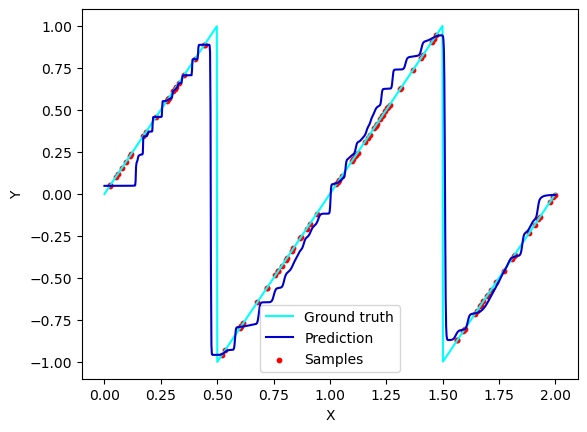

In [890]:
# Assign prototypes
X_data, Y_data = generate_data(fn, 100, x_min, x_max)
soft_nn.prototypes = X_data, Y_data
# Sample ground truth.
X = th.linspace(x_min, x_max, resolution).view(-1, 1)
Y = fn(X)
# Sample predictions.
Y_pred = soft_nn(X).detach()
# Plot everything.
plt.plot(X.view(-1), Y.view(-1), color='cyan', label='Ground truth')
plt.plot(X.view(-1), Y_pred.view(-1), color='mediumblue', label='Prediction')
plt.scatter(soft_nn.prototypes[0].view(-1), soft_nn.prototypes[1].view(-1), label='Samples', color='red', s=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
print('Loss: %.6f' % F.mse_loss(Y_pred, Y))
plt.show()